In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import glob
#import bioinfokit 
from bioinfokit import analys, visuz

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns',85)
pd.set_option('display.max_rows',100)

## my own function that gets the data
from Pi_GetData_fcn import GetData as GetData
from Pi_GetPiOverview_fcn import GetPiOverview as GetPiOverview

In [2]:
# define function
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same')/w

## What this script does:

    - it loads the pi data with the GetData function 
        - in that function it:
            1. shifts the window position so that it applies to the whole genome and not chromosome position
            2. all samples are joined in one data frame 
            3. there is df_shiftRaw with the raw data for %-window covered and pi per window
            4. there is also df_shiftNorm with the window pi multiplied with the frac
    - it calculated genome-wide pi values either with the raw data or normaliued data
        1. pi: uses the raw data
        2. piNorm: using the df_shiftNorm data 
        2. piNormwNaN: the final value is multiplied with the fraction of windows that are not nan

In [3]:
# read in data to panda
# get the number of unclassified reads from Kraken2 outputs

InPath="/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/subSample_pool500/"
#InPath="/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/defaultSet_500Cov/fractioncov_0.01/"

SamplePattern = "sub100"
files=glob.glob(InPath + "*" + SamplePattern + "*.pi")

outPath = "/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/O_output/"

chromosomes=["NC_003279.8","NC_003280.10","NC_003281.10","NC_003282.8","NC_003283.11","NC_003284.9","NC_001328.1"]
chromosomes_end = [1.50750e+07, 3.03500e+07, 4.41350e+07, 6.16300e+07, 8.25550e+07, 1.00270e+08, 1.00285e+08]

## option: 
#set all windows with less than minCov % covered with usable data to a pi of na
minCov=0.5


len(files)


344

In [4]:
## get sample names that are in there
samName_collect = []

for i in range(len(files)):
    a = files[i].split('/')
    sample=a[-1].split('_')

    sampleName="_".join(sample[0:4])

    samName_collect.append(sampleName)

samName_unique = list(set(samName_collect))
len(samName_unique)

55

In [5]:
## for the subsampling, get a loop for every sample
 
for i in range(len(samName_unique)):
    allSub_4_1sample = [s for s in files if samName_unique[i] in s]
    #print(allSub_4_1sample)
    #print("stopp")
    ## use the function to get the data 
    samName_collect, df_shiftRaw, df_shiftNorm, collect_NanNum = GetData(allSub_4_1sample, chromosomes, chromosomes_end, True)
    
    ## get pi for each of the samples, here they are collected in overview
    overview_1sample = GetPiOverview(samName_collect, df_shiftRaw, df_shiftNorm, collect_NanNum)

    ## average over all samples and get a collected df_1sample
    numbers = overview_1sample[["pi_mean","pi_std","piNorm_mean","piNorm_std","piNormwNaN_mean","piNormwNaN_std"]]
    numbers.mean().pi_mean
    
    # now get the averaged over all subsampled samples!
    indices = overview_1sample.index
    df_1sample = overview_1sample.drop(indices[1:])   # first initialize! and only keep the first row!
    
    df_1sample["pi_mean"] = numbers.mean().pi_mean
    df_1sample["pi_std"] = numbers.mean().pi_std
    df_1sample["piNorm_mean"] = numbers.mean().piNorm_mean
    df_1sample["piNorm_std"] = numbers.mean().piNorm_std
    df_1sample["piNormwNaN_mean"] = numbers.mean().piNormwNaN_mean
    df_1sample["piNormwNaN_std"] = numbers.mean().piNormwNaN_std

    df_1sample["NumNaNWindows"] =  np.mean(collect_NanNum)

    ## join with the other samples!
    if i==0:                                      ## in the first case, create overview
        overview = df_1sample
    else:                                         ## otherwise "just" add to the bottom
        overview = pd.concat([overview,df_1sample])

#overview

In [6]:
# extract data
overviewBB = overview.loc[(overview['treatment']=="bb") | (overview['treatment']=="anc")]
overviewnotBB = overview.loc[(overview['treatment']!="bb") | (overview['treatment']=="anc")]
overviewW0 = overview.loc[(overview['week']==0)]
overviewW1 = overview.loc[(overview['week']==1)]
overviewW15 = overview.loc[(overview['week']==15)]

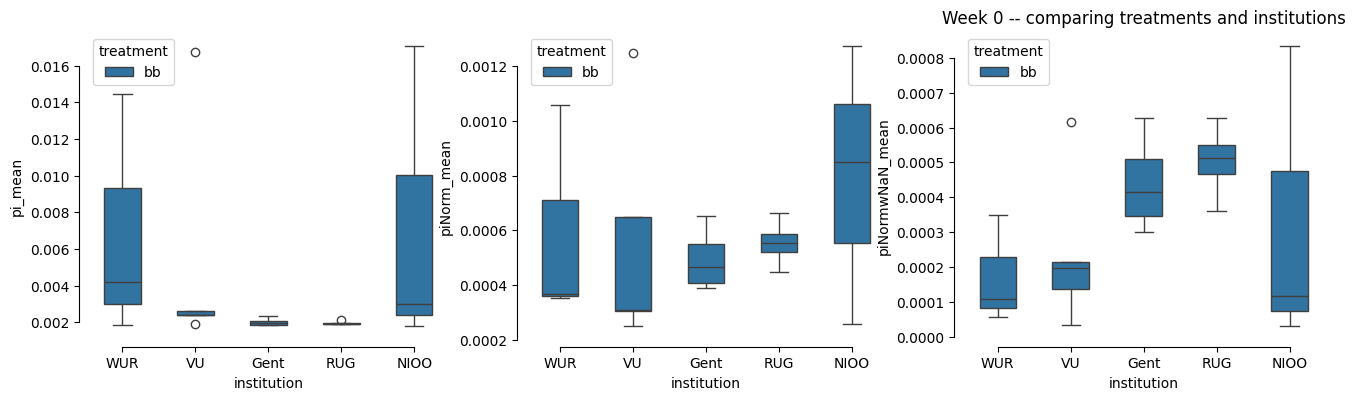

In [7]:
## hypothesis: different treatments start out with different diversity from the start:

fig1, ax1 = plt.subplots(1,3, figsize=(16,4))
plt.title('Week 0 -- comparing treatments and institutions')
sns.boxplot(data=overviewW15, x="institution", y="pi_mean", hue="treatment", width=0.5, ax=ax1[0])
#sns.move_legend(ax1[0], "upper left", bbox_to_anchor=(1, 1))
sns.boxplot(data=overviewW15, x="institution", y="piNorm_mean", hue="treatment", width=0.5, ax=ax1[1])
sns.boxplot(data=overviewW15, x="institution", y="piNormwNaN_mean", hue="treatment", width=0.5, ax=ax1[2])

#sns.move_legend(ax1[1], "upper left", bbox_to_anchor=(1, 1))

sns.despine(offset=5, trim=True)


<Axes: xlabel='NumNaNWindows', ylabel='pi_mean'>

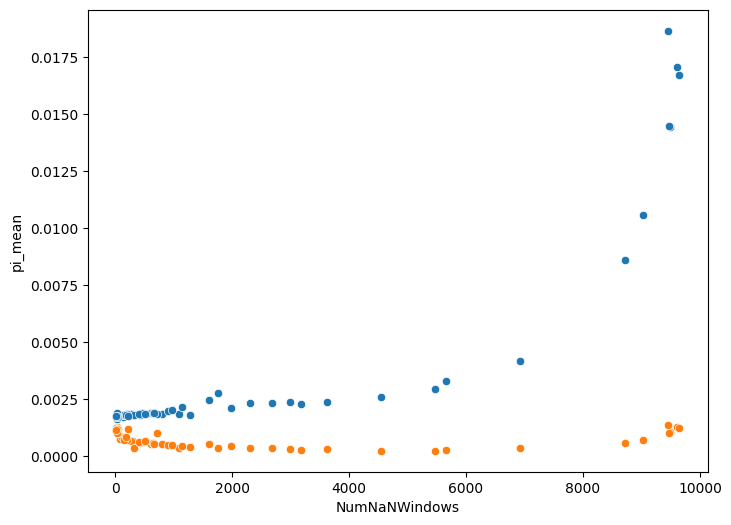

In [8]:
fig2, ax2 = plt.subplots(figsize=(8,6))
sns.scatterplot(overview, x="NumNaNWindows",y="pi_mean", ax=ax2)
sns.scatterplot(overview, x="NumNaNWindows",y="piNorm_mean", ax=ax2)
#sns.scatterplot(overview, x="NumNaNWindows",y="piNormwNaN_mean", ax=ax2)

In [9]:
### save the data:

overview.to_pickle(outPath + "PiDiversity_OVerview" + SamplePattern  + ".pkl")

In [10]:
collect_NanNum

array([8714., 8714., 8714., 8714., 8714., 8714., 8714., 8714., 8714.,
       8714.])